# Линейная регрессия

## Идея и математика

Линейная регрессия $-$ это алгоритм машинного обучения, который пытается восстановить линейную зависимость между признаками и целевой переменной.

Линейная зависимость $-$ это вот так:

$y(x_1, ..., x_n) = w_0 + w_1 * x_1 + ... + w_n * x_n$

При этом $w_1, ..., w_n$ называют коэффициентами или весами линейной регресии, а $w_0$ $-$ смещением, свободным коэффициентом или байесом. $x$ и $y$ $-$ это все так же признаки и целевая переменная соответственно.

Визуально для одного признака линейная регрессия выглядит так:

<img src="https://media.proglib.io/wp-uploads/2019/04/fig-lin-reg.jpg" width=800>

Каждая точка здесь $-$ это объект из выборки, а прямая $-$ это то, что мы получаем при обучении регрессии. Почему так?

Если мы посмотрим на формулу выше, записанную для одного признака, то мы увидим уравнение прямой с угловым коэффициентом $w_1$ (на картинке $b_1$).

$y(x_1) = w_0 + w_1 * x_1$

### Обучение

Параметры (коэффициенты и смещение) в линейной регрессии подбираются методом минимизации среднеквадратичной ошибки.

$MSE = \frac {1} {n} * \displaystyle\sum_{i=1}^n (y - \widehat y) ^ 2$

При этом после подсчета ошибки есть два варианта:
- Честно решить задачу поиска оптимума напрямую: взять функцию потерь, посчитать производную и т.д. (не всегда возможно и не всегда быстро)
- Постепенно подбирать все более подходящий ответ (всегда возможно, но чаще всего долго)


### Гиперпараметры

У базовой линейной регресии гиперпараметров скорее нет. При большом желании мы можем считать гиперпараметром функцию потерь (квадратичная или абсолютная ошибка) или используемый алгоритм обучения. Но на практике эти параметры почти никогда не меняют.

### Плюсы и минусы линейной регрессии

__Плюсы__:
- Сравнительно быстро и просто обучается
- Очень легко интерпретируется
- Обобщает, а не просто заучивает выборку
- Хороший инструмент разведочного анализа данных (мы можем строить регрессии и из них делать выводы о взаимосвязи переменных)
- Сложно создать ситуацию для переобучения (прямая $-$ _не самый гибкий_ из геометрических объектов)

__Минусы__:
- Может предсказать только линейные зависимости (чинится использованием полиномиальной регресии, но при этом сильно возрастает количество вычислений)
- Ломается при наличии линейно скоррелированных признаков (код не сломается, но из-за наличия разных решений коэффициенты могут быть весьма странными)
- Плохо работает с ненормированными признаками
- Чувствительна к шуму и выбросам
- Нет параметров для настройки

## Практика

Скачаем [датасет с кагла](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression). Будем предсказывать успехи студента в учебе на основе предшствующих успехов и нескольких других параметров

In [ ]:
!curl -L -o dataset.zip https://www.kaggle.com/api/v1/datasets/download/nikhil7280/student-performance-multiple-linear-regression
!unzip dataset.zip
# может не сработать в jupyter, можно подобрать другое решение ии по старинке скачать руками - https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression

Всякие полезные импорты

In [2]:
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score

%matplotlib inline
warnings.filterwarnings('ignore')

Прочитаем скачанные данные

In [3]:
df = pd.read_csv('Student_Performance.csv')
df.head(3)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0


Заметим, что все значения числовые, кроме колонки "Extracurricular Activities", которая имеет значение "Yes/No". Давайте заменим ее на число так, что 1 будет означать "Yes", а 0 $-$ "No".

In [4]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].apply(lambda x: int(x == 'Yes'))
df.head(3)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0


Посмотрим, коррелируют ли признаки между собой. Это важно сделать по двум причинам:
- Линейная регрессия имеет привычку ломаться из-за таких признаков
- Так мы сможем сделать предположения о важности признаков и их влиянии на таргет (если включим его в график)

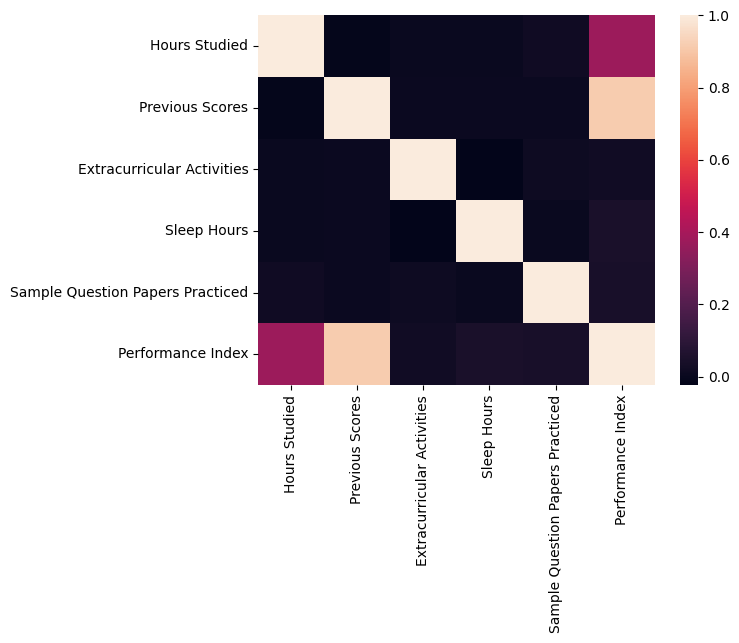

In [5]:
sns.heatmap(df.corr('pearson'));

Мы увидели, что признаки между собой не коррелируют, так что все хорошо. А вот в плане важности можно ожидать наибольший вклад со стороны признаков "Hours Studied" и "Previous Scores".

Теперь посмотрим на распределение таргета, чтобы понимать, какое значение ошибки считать большим

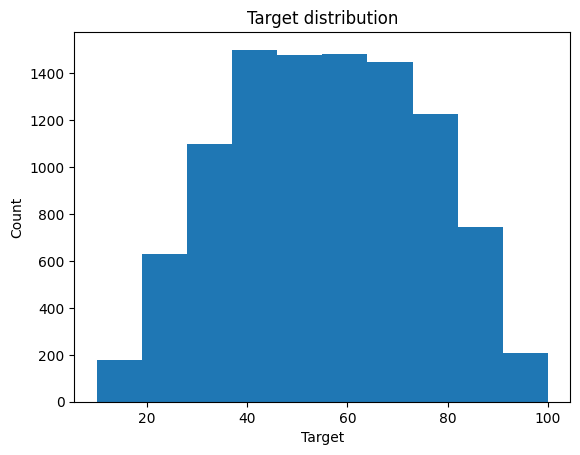

In [6]:
fig, ax = plt.subplots()
ax.hist(df['Performance Index'])
ax.set_title('Target distribution')
ax.set_xlabel('Target')
ax.set_ylabel('Count');

Поделим наши данные на две выборки (нет гиперпараметров $-$ не нужна валидационная!).

In [7]:
train, test = train_test_split(df, test_size=0.25, random_state=42)
train.shape, test.shape

((7500, 6), (2500, 6))

In [8]:
x_train, y_train = train.loc[:, :'Sample Question Papers Practiced'].to_numpy(), \
    train['Performance Index'].to_numpy()

x_test, y_test = test.loc[:, :'Sample Question Papers Practiced'].to_numpy(), \
    test['Performance Index'].to_numpy()

Сначала проверим, что будет, если мы для всего предскажем среднее значение по обучающей выборке. Для задачи линейной регрессии мы можем смотреть на среднюю абсолютную или среднюю квадратичную ошибку (среднюю абсолютную легче интерпретировать), а также на метрику $R^2$, которая показывает, какая доля дисперсии (вариативности наших данных) объяснена нашей моделью. Чем ближе к 1, тем лучше, а если она опустилась ниже нуля, значит, предсказание совсем слабое.

In [9]:
mn = y_train.mean()
pred = [mn for _ in y_test]
r2_score(y_test, pred), mean_absolute_error(y_test, pred)

(-0.001627662324651613, 16.19852352)

Получается, что ошибаемся мы в среднем на 16 баллов (значение средней абсолютной ошибки) и совершенно не учитываем вариативность наших данных ($R^2$ в районе нуля).

Ради интереса проверим, что будет в случае случайной генерации ответа:
- мат. ожидание и стандартное отклонение возьмем по выборке,
- используем нормальное распределение, так как распределение таргета визуально на него похоже

<img src="https://www.scribbr.com/wp-content/uploads/2023/02/standard-normal-distribution-example.webp" width=500>

In [10]:
np.random.seed(42) # чтобы результат не менялся при перезапуске

pred = np.random.normal(
    loc=y_train.mean(),
    scale=y_train.std(),
    size=y_test.shape
    )

r2_score(y_test, pred), mean_absolute_error(y_test, pred)

(-0.9782433529413106, 21.64410602077782)

Очевидно, все стало хуже. Но зато мы теперь знаем границу, ниже которой падать нельзя :)

Обучим наконец регресию (`score` = $R^2$)

In [11]:
reg = LinearRegression()
reg.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [12]:
pred = reg.predict(x_test)
r2_score(y_test, pred), mean_absolute_error(y_test, pred) #reg.score(x_test, y_test) также покажет r^2

(0.9890550757439104, 1.5975792091646108)

Заметим, что все стало сильно лучше. Ошибаемся в среднем на 1.6 (это в 10 раз меньше!) и объсняем значительную часть вариативности ($R^2 = 0.99$)

Теперь попробуем немного проанализировать получившуюся модель. Из нее можно достать веса, сделаем это:

In [13]:
reg.coef_

array([2.85492123, 1.01637916, 0.58370931, 0.47688351, 0.19092346])

Если теперь соотнести их с признаками из датасета, то станет видно, что наше предположение о важных признаках оказалось правильным:

In [14]:
for col, coef in zip(df.columns[:-1], reg.coef_):
    print(f'{col}: {round(coef, 3)}')

Hours Studied: 2.855
Previous Scores: 1.016
Extracurricular Activities: 0.584
Sleep Hours: 0.477
Sample Question Papers Practiced: 0.191


## Другие регрессии

Как мы уже сказали, у базовой линейной регрессии есть значительное количество недостатков. По этой причине появились другие виды линейных регрессий, которые позволяют учитывать более сложные зависимости (как полиномиальная) или более стойко переносить выбросы и шум в данных.

### Ridge, Lasso, ElasticNet

Иногда случается такое, что веса модели становятся излишне большими: вместо $y(x_1) = x_1 + 5$ получаем $y(x_1) = 1000 * x_1 - 10000$, которое может неплохо предсказывать на наших данных, но иметь ужасную устойчивость к изменениям (сравните, что произойдет при увеличении $x_1$ на 1 в первом и втором случае). Для того, чтобы этого не происходило, была придумана __регуляризация__.

Чаще всего она заключается в дополнении функции потерь слагаемым, отвечающим за ограничение диапазона для весов. В зависимости от способа ограничения есть три самых частых вида регуляризации:
- Ridge (L2-norm) $-$ сумма квадратов весов
- Lasso (L1-norm) $-$ сумма модулей весов
- ElasticNet $-$ линейная комбинация L1- и L2-нормы

<img src="https://analyticsindiamag.com/wp-content/uploads/2021/08/image-143.png" width=500>

А на наших данных результаты те же, так как задача достаточно простая и признаки хорошие.

In [15]:
rdg = Ridge(alpha=0.5)
rdg.fit(x_train, y_train)
pred = rdg.predict(x_test)

rdg.score(x_test, y_test), mean_absolute_error(y_test, pred)

(0.9890550526137291, 1.5975796151534185)

### Polynomial

Линейная регрессия умеет приближать только линейный зависимости (увы). Но мы можем дать ей возможность работать с более сложными данными, если добавим в признаки комбинации и степени весов.

<img src="https://blog.sf.education/wp-content/uploads/2021/06/1-1.jpg">

Тогда вместо

$y(x_1) = w_1 * x_1 + w_0$

мы можем получить:

$y(x_1) = w_{1,2} * x_1^2 + w_1 * x_1 + w_0$,

что дает нам параболу.



Посмотрим на практике. Для этого заведем игрушечные данные: создадим 1000 точек параболы вида $y = x^2$ и добавим к ним случайного шума

In [16]:
diff = (-50, 50)
n = 1000

x = np.linspace(*diff, n).reshape(-1, 1)
y = x ** 2  + np.random.normal(0, 100, (n, 1))

Сначада обучим обычную линейную регрессию и увидим, насколько плохо она справляется

In [17]:
reg = LinearRegression()
reg.fit(x, y)
pred = reg.predict(x)

reg.score(x, y), mean_absolute_error(y, pred)

(1.8996592903164355e-06, 650.2165421453377)

In [18]:
round(reg.score(x, y), 5) # для более человекочитаемого результата r^2

0.0

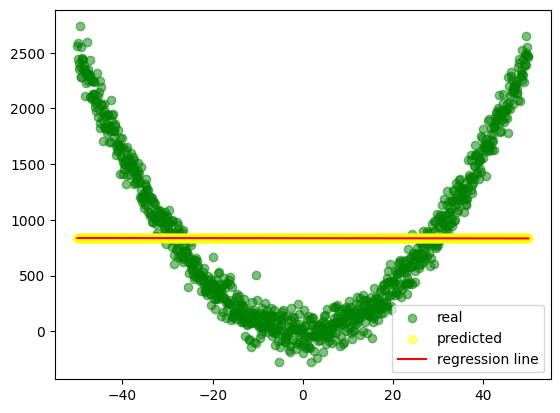

In [19]:
fig, ax = plt.subplots()
ax.scatter(x, y, color='g', label='real', alpha=0.5)
ax.scatter(x, pred, color='yellow', label='predicted', alpha=0.5)

xs = np.array(diff)
ys = xs * reg.coef_[0,0] + reg.intercept_
ax.plot(xs, ys, color='red', label='regression line')

ax.legend()

plt.show()

А теперь добавим к данным квадраты признаков и повторим предыдущее

In [20]:
new_x = np.hstack([x, x ** 2])

reg = LinearRegression()
reg.fit(new_x, y)
pred = reg.predict(new_x)

reg.score(new_x, y), mean_absolute_error(y, pred)

(0.9817996753614372, 81.91851738935345)

И метрики, и визуализация показывают сильно более высокое качество

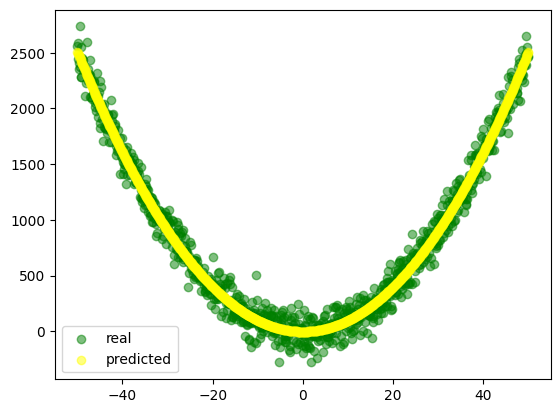

In [21]:
fig, ax = plt.subplots()
ax.scatter(x, y, color='g', label='real', alpha=0.5)
ax.scatter(x, pred, color='yellow', label='predicted', alpha=0.5)

ax.legend()

plt.show()